In [2]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier

# new helpers:
from shared import dataset_local_path, bootstrap_accuracy, simple_boxplot, TODO

# stdlib:
from dataclasses import dataclass
import json
from typing import Dict, Any, List

In [3]:
examples = []
ys = []

with open(dataset_local_path("poetry_id.jsonl")) as fp:
    for line in fp:
        info = json.loads(line)
        # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
        keep = info["features"]
        # whether or not it's poetry is our label.
        ys.append(info["poetry"])
        # hold onto this single dictionary.
        examples.append(keep)

## CONVERT TO MATRIX:

feature_numbering = DictVectorizer(sort=True)
X = feature_numbering.fit_transform(examples)

print("Features as {} matrix.".format(X.shape))


## SPLIT DATA:

RANDOM_SEED = 12345678

# Numpy-arrays are more useful than python's lists.
y = np.array(ys)
# split off train/validate (tv) pieces.
X_tv, X_test, y_tv, y_test = train_test_split(
    X, y, train_size=0.75, shuffle=True, random_state=RANDOM_SEED
)
# split off train, validate from (tv) pieces.
X_train, X_vali, y_train, y_vali = train_test_split(
    X_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

print(X_train.shape, X_vali.shape, X_test.shape)


Features as (2772, 38) matrix.
(1372, 38) (707, 38) (693, 38)


In [4]:
@dataclass
class ExperimentResult:
    vali_acc: float
    params: Dict[str, Any]
    model: ClassifierMixin


In [5]:
def consider_decision_trees():
    print("Consider Decision Tree.")
    performances: List[ExperimentResult] = []

    for rnd in range(3):
        for crit in ["entropy"]:
            for d in range(1, 9):
                params = {
                    "criterion": crit,
                    "max_depth": d,
                    "random_state": rnd,
                }
                f = DecisionTreeClassifier(**params)
                f.fit(X_train, y_train)
                vali_acc = f.score(X_vali, y_vali)
                result = ExperimentResult(vali_acc, params, f)
                performances.append(result)
    return max(performances, key=lambda result: result.vali_acc)


def consider_random_forest():
    print("Consider Random Forest.")
    performances: List[ExperimentResult] = []
    # Random Forest
    for rnd in range(3):
        for crit in ["entropy"]:
            for d in range(4, 9):
                params = {
                    "criterion": crit,
                    "max_depth": d,
                    "random_state": rnd,
                }
                f = RandomForestClassifier(**params)
                f.fit(X_train, y_train)
                vali_acc = f.score(X_vali, y_vali)
                result = ExperimentResult(vali_acc, params, f)
                performances.append(result)
    return max(performances, key=lambda result: result.vali_acc)


def consider_perceptron() -> ExperimentResult:
    print("Consider Perceptron.")
    performances: List[ExperimentResult] = []
    for rnd in range(3):
        params = {
            "random_state": rnd,
            "penalty": None,
            "max_iter": 1000,
        }
        f = Perceptron(**params)
        f.fit(X_train, y_train)
        vali_acc = f.score(X_vali, y_vali)
        result = ExperimentResult(vali_acc, params, f)
        performances.append(result)

    return max(performances, key=lambda result: result.vali_acc)


def consider_logistic_regression() -> ExperimentResult:
    print("Consider Logistic Regression.")
    performances: List[ExperimentResult] = []
    for rnd in range(3):
        params = {
            "random_state": rnd,
            "penalty": "l2",
            "max_iter": 100,
            "C": 1.0,
        }
        f = LogisticRegression(**params)
        f.fit(X_train, y_train)
        vali_acc = f.score(X_vali, y_vali)
        result = ExperimentResult(vali_acc, params, f)
        performances.append(result)

    return max(performances, key=lambda result: result.vali_acc)


def consider_neural_net() -> ExperimentResult:
    print("Consider Multi-Layer Perceptron.")
    performances: List[ExperimentResult] = []
    for rnd in range(3):
        params = {
            "hidden_layer_sizes": (32,),
            "random_state": rnd,
            "solver": "lbfgs",
            "max_iter": 500,
            "alpha": 0.0001,
        }
        f = MLPClassifier(**params)
        f.fit(X_train, y_train)
        vali_acc = f.score(X_vali, y_vali)
        result = ExperimentResult(vali_acc, params, f)
        performances.append(result)

    return max(performances, key=lambda result: result.vali_acc)


logit = consider_logistic_regression()
perceptron = consider_perceptron()
dtree = consider_decision_trees()
rforest = consider_random_forest()
mlp = consider_neural_net()

print("Best Logistic Regression", logit)
print("Best Perceptron", perceptron)
print("Best DTree", dtree)
print("Best RForest", rforest)
print("Best MLP", mlp)


Consider Logistic Regression.
Consider Perceptron.
Consider Decision Tree.
Consider Random Forest.
Consider Multi-Layer Perceptron.
Best Logistic Regression ExperimentResult(vali_acc=0.8925035360678925, params={'random_state': 0, 'penalty': 'l2', 'max_iter': 100, 'C': 1.0}, model=LogisticRegression(random_state=0))
Best Perceptron ExperimentResult(vali_acc=0.9038189533239038, params={'random_state': 0, 'penalty': None, 'max_iter': 1000}, model=Perceptron())
Best DTree ExperimentResult(vali_acc=0.9335219236209336, params={'criterion': 'entropy', 'max_depth': 5, 'random_state': 2}, model=DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2))
Best RForest ExperimentResult(vali_acc=0.9462517680339463, params={'criterion': 'entropy', 'max_depth': 8, 'random_state': 0}, model=RandomForestClassifier(criterion='entropy', max_depth=8, random_state=0))
Best MLP ExperimentResult(vali_acc=0.925035360678925, params={'hidden_layer_sizes': (32,), 'random_state': 1, 'solver': 'lbfgs

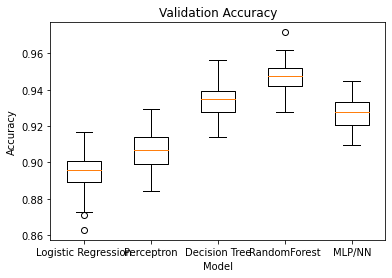

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [6]:
%matplotlib inline

# Helper method to make a series of box-plots from a dictionary:
simple_boxplot(
    {
        "Logistic Regression": bootstrap_accuracy(logit.model, X_vali, y_vali),
        "Perceptron": bootstrap_accuracy(perceptron.model, X_vali, y_vali),
        "Decision Tree": bootstrap_accuracy(dtree.model, X_vali, y_vali),
        "RandomForest": bootstrap_accuracy(rforest.model, X_vali, y_vali),
        "MLP/NN": bootstrap_accuracy(mlp.model, X_vali, y_vali),
    },
    title="Validation Accuracy",
    xlabel="Model",
    ylabel="Accuracy",
    save="model-cmp.png",
)

In [7]:
TODO("1. Understand consider_decision_trees; I have 'tuned' it.")
TODO("2. Find appropriate max_iter settings to stop warning messages.")
TODO(
    "3. Pick a model: {perceptron, logistic regression, neural_network} and optimize it!"
)

TODO: 1. Understand consider_decision_trees; I have 'tuned' it.


SystemExit: -1